### Pricing Vanilla Options using an Exotic Engine
Features:
1. Visualise implied vol surface
2. Calibrate local vol surface
3. Re-price options to check if smile is captured

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

from ExoticEngine.Payoff import Options as O
from ExoticEngine.Statistics import Statistics as Stats
from ExoticEngine.MarketDataObject import Parameter as P
from ExoticEngine.MarketDataObject.VolatilitySurfaces import VolatilitySurface as VS
from ExoticEngine.MarketDataObject.VolatilitySurfaces import LocalVolatility as LV
from ExoticEngine.MarketDataObject.VolatilitySurfaces import (
    VolatilityInterpolators as VI,
)

from ExoticEngine import MonteCarloPricer as Pricer

In [2]:
implied_vol_data = pd.read_csv("OptionPremiumQuotes.csv", index_col=0)
implied_vol_data

,50.00,60.00,70.00,80.00,85.00,90.00,95.00,100.00,105.00,110.00,115.00,120.00,130.00,140.00,150.00
Years,,,,,,,,,,,,,,,
0.1,1.185,0.822,0.533,0.316,0.236,0.173,0.129,0.103,0.095,0.106,0.135,0.182,0.331,0.553,0.848
0.2,1.147,0.798,0.519,0.311,0.234,0.173,0.131,0.106,0.099,0.109,0.136,0.182,0.325,0.539,0.823
0.3,1.110,0.774,0.507,0.306,0.232,0.174,0.133,0.109,0.102,0.112,0.138,0.182,0.320,0.525,0.798
0.4,1.074,0.752,0.494,0.302,0.230,0.174,0.135,0.112,0.105,0.114,0.140,0.182,0.315,0.512,0.775
0.5,1.040,0.730,0.482,0.297,0.228,0.175,0.137,0.115,0.108,0.117,0.142,0.182,0.310,0.500,0.752
0.6,1.008,0.709,0.471,0.293,0.227,0.175,0.139,0.117,0.111,0.120,0.144,0.182,0.305,0.488,0.731
0.7,0.977,0.690,0.460,0.289,0.225,0.176,0.141,0.120,0.114,0.123,0.145,0.183,0.301,0.476,0.710
0.8,0.947,0.671,0.450,0.286,0.224,0.176,0.143,0.123,0.117,0.125,0.147,0.183,0.297,0.466,0.690
0.9,0.918,0.652,0.441,0.282,0.223,0.177,0.145,0.126,0.120,0.128,0.149,0.184,0.293,0.455,0.671


In [3]:
# market observable
rate = 0.05
vol = 0.1

rate_dynamics = lambda t: rate
vol_dynamics = lambda t: vol
repo_dynamics = lambda t: 0
div_dynamics = lambda t: 0

Rate = P.Parameter(param=rate_dynamics)
Vol = P.Parameter(param=vol_dynamics)
Repo = P.Parameter(param=repo_dynamics)
Div = P.Parameter(param=div_dynamics)

vol_surface = VS.VolatilitySurfaceBlackScholes(
    implied_vol_data, Rate, Repo, 100, "bilinear"
)

Implied vol surface

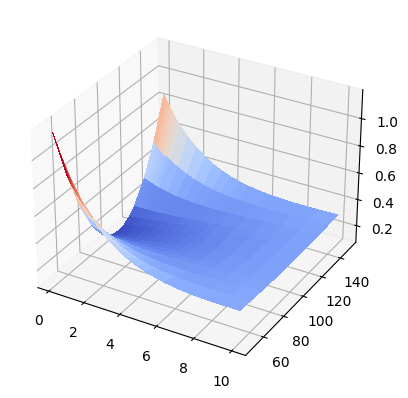

In [4]:
vol_surface.plot_surface()

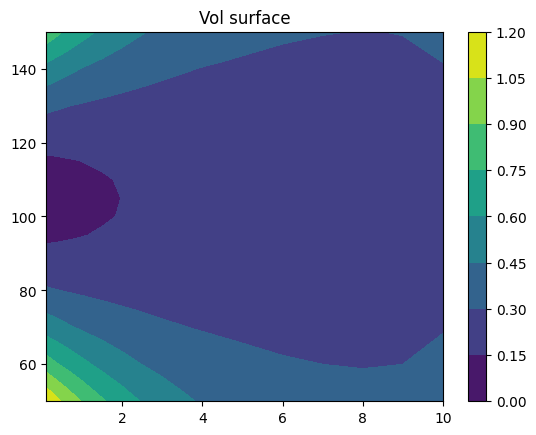

In [5]:
vol_surface.plot_contour()

Local Vol

In [6]:
local_vol = LV.BSLocalVolatilitySurface(vol_surface)

In [20]:
Ks = np.linspace(55,145,20)
Ts = np.linspace(0.3,2,15)
local_vol_surface = np.zeros([20,15])
local_vol_surface_dupire = np.zeros([20,15])

In [21]:
# interpolation is extremely slow...!! Why so slow...?
for i,k in enumerate(Ks):
    for j,t in enumerate(Ts):
        #local_vol_surface[i][j] = local_vol.local_vol(k,t)
        local_vol_surface_dupire[i][j] = local_vol.local_vol_dupire(k,t)

/opt/homebrew/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=20,26 m=345 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [22]:
TT, KK = np.meshgrid(Ts, Ks)

Local Vol surface - using implied vol calibration

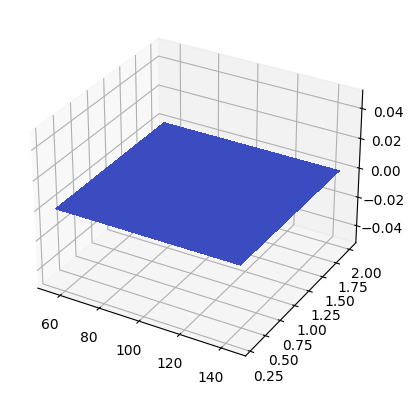

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(KK, TT, local_vol_surface, cmap=cm.coolwarm, linewidth=0, antialiased=False
        )

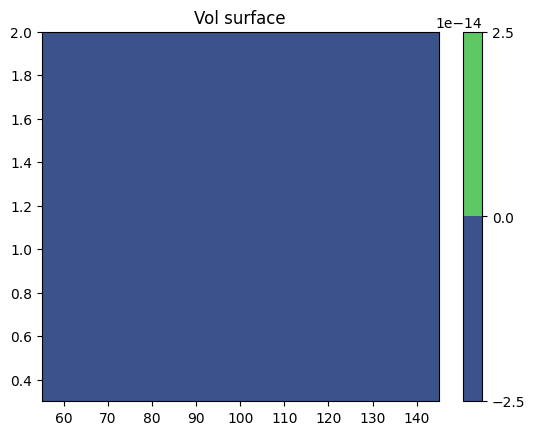

In [24]:
fig, ax = plt.subplots(1, 1)
cp = ax.contourf(KK, TT, local_vol_surface)
fig.colorbar(cp)  # Add a colorbar to a plot
ax.set_title("Vol surface")
plt.show()

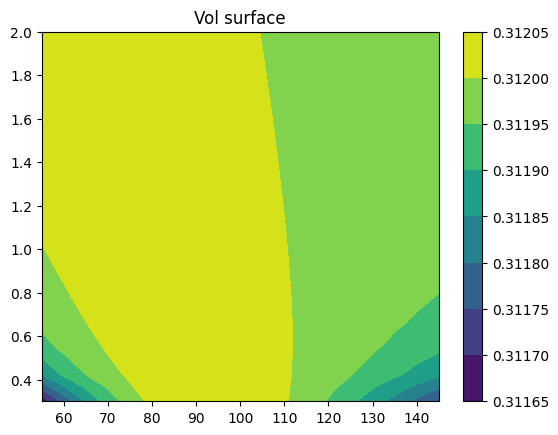

In [25]:
fig, ax = plt.subplots(1, 1)
cp = ax.contourf(KK, TT, local_vol_surface_dupire)
fig.colorbar(cp)  # Add a colorbar to a plot
ax.set_title("Vol surface")
plt.show()

Local Vol surface - using call premium calibration

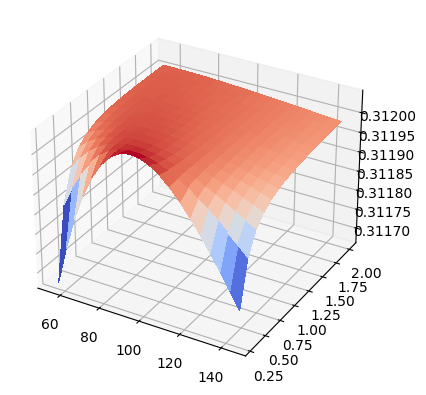

In [26]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(KK, TT, local_vol_surface_dupire, cmap=cm.coolwarm, linewidth=0, antialiased=False
                       )